In [1]:
#
# phase4 :
#   Logistic regression Bayesian learning
#
%matplotlib inline
import os
os.environ['THEANO_FLAGS'] = "mode=FAST_RUN,device=cpu,floatX=float32"
import theano
import theano.tensor as T
import config
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

/Library/Python/2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import network
import network.normFlow as nf
import network.meanField as mf
import utils
import utils.mathT as mathT
import utils.mathZ as mathZ
import utils.theanoGeneral as utilsT
import utils.optimizers as optimizers
import utils.plotZ as plotZ
import models
import models.moon as moon
import pandas as pd
import seaborn as sns  # statistical plots
floatX = utils.floatX

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [4]:
# SOFTMAX PROBLEM
SAVE_FLAG = True
DIMX = 2
DIMY = 3
LENW = DIMX * DIMY
ROOT = '../report/figs/bayes/softmax/mf/'
print 'Saving flag : %s\nToot path   : %s' %(SAVE_FLAG, ROOT)
model = moon.Multiclass(DIMX,DIMY)
PRIOR_WEIGHT = 0.1
data = np.load(ROOT+'/../record_L4.npz')
SOFTMAX = True

Saving flag : True
Toot path   : ../report/figs/bayes/softmax/mf/


In [3]:
# LOGISTIC REGRESSION
SAVE_FLAG = True
DIMX = 2
DIMY = 1
LENW = DIMX
ROOT = '../report/figs/bayes/logistic/mf/'
print 'Saving flag : %s\nToot path   : %s' %(SAVE_FLAG, ROOT)
model = moon.Logistic(DIMX)
model.setPriorCenter(0.0)
PRIOR_WEIGHT = 0.05
data = np.load(ROOT+'/../exp1/record_L4.npz')
SOFTMAX = False

Saving flag : True
Toot path   : ../report/figs/bayes/logistic/mf/


In [5]:
##
## VARIATIONAL INFERENCE : mean-field
##            parameter setup
##
SAMPLINGNUM = 20
DIMNF = LENW+DIMY
NUMITER = 10000

In [6]:
# construction variational model
vi = mf.MeanField(DIMNF)
z, logqz = vi.getZ(SAMPLINGNUM)

# matching latent variables to parameters
# SOFTMAX
if SOFTMAX:
    wt = z[:, :LENW].reshape( (SAMPLINGNUM,DIMX,DIMY) ); bt = z[:, LENW:]
# LOGISTIC
else:
    wt = z[:, :DIMX]; bt = z[:,-1]

print 'w : %s\nb : %s\nlogqz : %s' % ( wt.shape.eval(), bt.shape.eval(), logqz.shape.eval() )

w : [20  2]
b : [20]
logqz : [20]


In [7]:
# setting cost variable
x = utils.theanoGeneral.sharedf(data['x'])
y = utils.theanoGeneral.sharedf(data['y'])

logpy_xw, temp = model.logPy_xw(x,y,wt,bt)
logpw = model.logPw(wt,bt)

In [8]:
# ELBO
cost = T.mean( logqz - ( logpy_xw + logpw*PRIOR_WEIGHT ) )  # negative-ELBO

params = vi.getParams()
grads = [ T.grad(cost,p) for p in params ]

In [9]:
# optimisation setup
vi.reInit()
opt = optimizers.SGD( params,lr=0.05,momentum=0.5,decay=0.001)
updates = opt.getUpdates(params,grads)

outputs = [ cost, T.mean(logpy_xw), T.mean(logqz) ]
estep = theano.function(inputs=[],outputs=outputs, updates=updates)

In [10]:
# training

keys = ['cost','pxyw','qz']
record = {}

# mb.setStd(0.7)
for k in keys:
    record[k] = []
for i in range(NUMITER):
    out = estep()
    for i,q in enumerate(out):
        record[keys[i]].append( q )        
for k in keys:
    record[k] = np.asarray( record[k] )

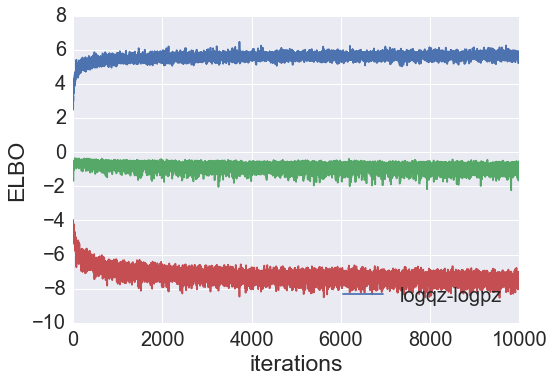

In [11]:
# plt.plot( range(NUMITER), record['cost'],'-' )
# plt.show()
xs = range(NUMITER)
plt.plot( xs, -record['cost'], '-', label='logqz-logpz')
plt.xlabel('iterations',fontsize=23)
plt.ylabel('ELBO',fontsize=23)
plt.tick_params(axis='both', which='major', labelsize=9)
plt.legend(fontsize=20,loc=4)
plt.tick_params(axis='both', which='major', labelsize=20)
if SAVE_FLAG:
    plt.savefig(ROOT+'/elbo.png')
plt.plot( xs, record['pxyw'], '-', label='log-pxz')
plt.plot( xs, record['qz'], '-', label='log-qz')
plt.show()

In [12]:
###
### SAVING
###
SAVEPATH = ROOT+'/record.npz'
np.savez(SAVEPATH, x = data['x'], y=data['y'], 
            numiter=NUMITER, nftype='mf',
            cost=record['cost'])

0.677354
0.678555333333
0.68589
0.691288666667


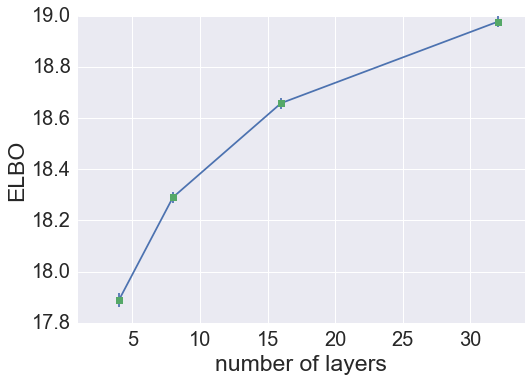

In [165]:
## INDEPENDENT
##     Statistica of the variational bound
##     

NUM_LS = [4,8,16,32]

rs = list()
costs = list()
for i, L in enumerate(NUM_LS):
    rs.append(  np.load(ROOT+'/record_L%d.npz'%L) )
    costs.append( -rs[-1]['cost'][-500:] )
    print rs[-1]['acc']
costs = np.asarray( costs )
bars = [ np.var(costs[i]) for i in range(len(NUM_LS)) ]
costs = np.mean(costs,axis=1)

plt.errorbar(NUM_LS,costs,yerr=bars)
plt.plot( NUM_LS, costs, 's')
    
plt.xlabel('number of layers',fontsize=23)
plt.ylabel('ELBO',fontsize=23)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlim([1,NUM_LS[-1]+2])
# plt.legend(fontsize=20)
plt.savefig(ROOT+'/ELBOvsL.png')

In [ ]:
wn = np.asarray([[1,-1,2],
                 [1,-1,-2]]) 
bn = np.asarray([1, 1, 3])  

ww = np.asarray( [wn,wn] )
bb = np.asarray( [bn,bn] )

lout = model_t.nPredict(data['x'],ww,bb)
acc, acc_ = model_t.nAcc(data['label'],lout)
print np.mean( acc )
print np.var(acc)

